# Extract, Load, Filter

In [1]:
import pandas as pd
import zipfile
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn's aesthetic parameters to match Matplotlib's
sns.set()

### Extract ###

# Define path to the zip file
zip_path = 'fr.openfoodfacts.org.products.csv.zip'

# Define path to the csv file you want to extract
csv_path = 'fr.openfoodfacts.org.products.csv'

unzip = False

# Open and extract the csv file
if unzip:
    with zipfile.ZipFile(zip_path, 'r') as zfile:
        zfile.extract(csv_path)

### Load ###

# Now we can read the extracted csv file into a DataFrame
df = pd.read_csv(csv_path, delimiter="\t", low_memory=False)

orignal_columns = df.columns.to_frame()

print(df.shape)

(320772, 162)


In [2]:
### Filter ###

# Drop 100% missing values
df.dropna(how="all", axis="columns", inplace=True)
df.drop_duplicates(inplace=True)

columns_kept = []
columns_removed = []

threshold = 0.5

for col in df.columns.to_list():

    # assuming df is your DataFrame and 'column1' is your column
    missing_values_count = df[col].isnull().sum()
    total_values = len(df[col])

    if missing_values_count / total_values > threshold:
        #print(f"More than 50% of the values in {col} are missing.")
        df.drop(col, axis="columns", inplace=True)
        columns_removed.append(col)

    else:
        #print(f"Less than or equal to 50% of the values in {col} are missing.")
        columns_kept.append(col)

print(df.shape)
#pd.DataFrame.from_dict({"columns kept": columns_kept, "columns removed": columns_removed})

col_summary_df = pd.DataFrame([columns_kept,columns_removed]).T
col_summary_df.columns = ["Kept Columns", "Removed Columns"]
col_summary_df

(320772, 34)


Kept Columns                   Removed Columns
0                code                      generic_name
1                 url                          quantity
2             creator                         packaging
3           created_t                    packaging_tags
4    created_datetime                        categories
..                ...                               ...
107              None                           ph_100g
108              None       fruits-vegetables-nuts_100g
109              None  collagen-meat-protein-ratio_100g
110              None                        cocoa_100g
111              None             carbon-footprint_100g

[112 rows x 2 columns]

In [5]:
print(col_summary_df["Kept Columns"].to_list())

['brands_tags', 'countries_tags', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr']

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size', 'additives_n', 'additives', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'states', 'states_tags', 'states_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

In [9]:
categories = ['brands_tags', 'countries_tags', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr']
numerical = df.select_dtypes(include=[np.number]).columns.tolist()

In [11]:
df[categories]

brands_tags    countries_tags  additives_n  \
0       ferme-t-y-r-nao         en:france          NaN   
1                   NaN  en:united-states          0.0   
2          torn-glasser  en:united-states          0.0   
3             grizzlies  en:united-states          0.0   
4        bob-s-red-mill  en:united-states          0.0   
...                 ...               ...          ...   
320767          panzani        en:romania          NaN   
320768     trader-joe-s  en:united-states          0.0   
320769               乐吧          en:china          NaN   
320770            knorr         en:france          NaN   
320771    market-pantry  en:united-states          7.0   

        ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0                               NaN                                      NaN   
1                               0.0                                      0.0   
2                               0.0                                      0.0   
3                               0.0                                      0.0   
4                               0.0                                      0.0   
...                             ...                                      ...   
320767                          NaN                                      NaN   
320768                          0.0                                      0.0   
320769                          NaN                                      NaN   
320770                          NaN                                      NaN   
320771                          0.0                                      0.0   

       nutrition_grade_fr  
0                     NaN  
1                       d  
2                       b  
3                       d  
4                     NaN  
...                   ...  
320767                NaN  
320768                  b  
320769                NaN  
320770                NaN  
320771                NaN  

[320772 rows x 6 columns]

# Impute Missing Values & Replace Extreme Values

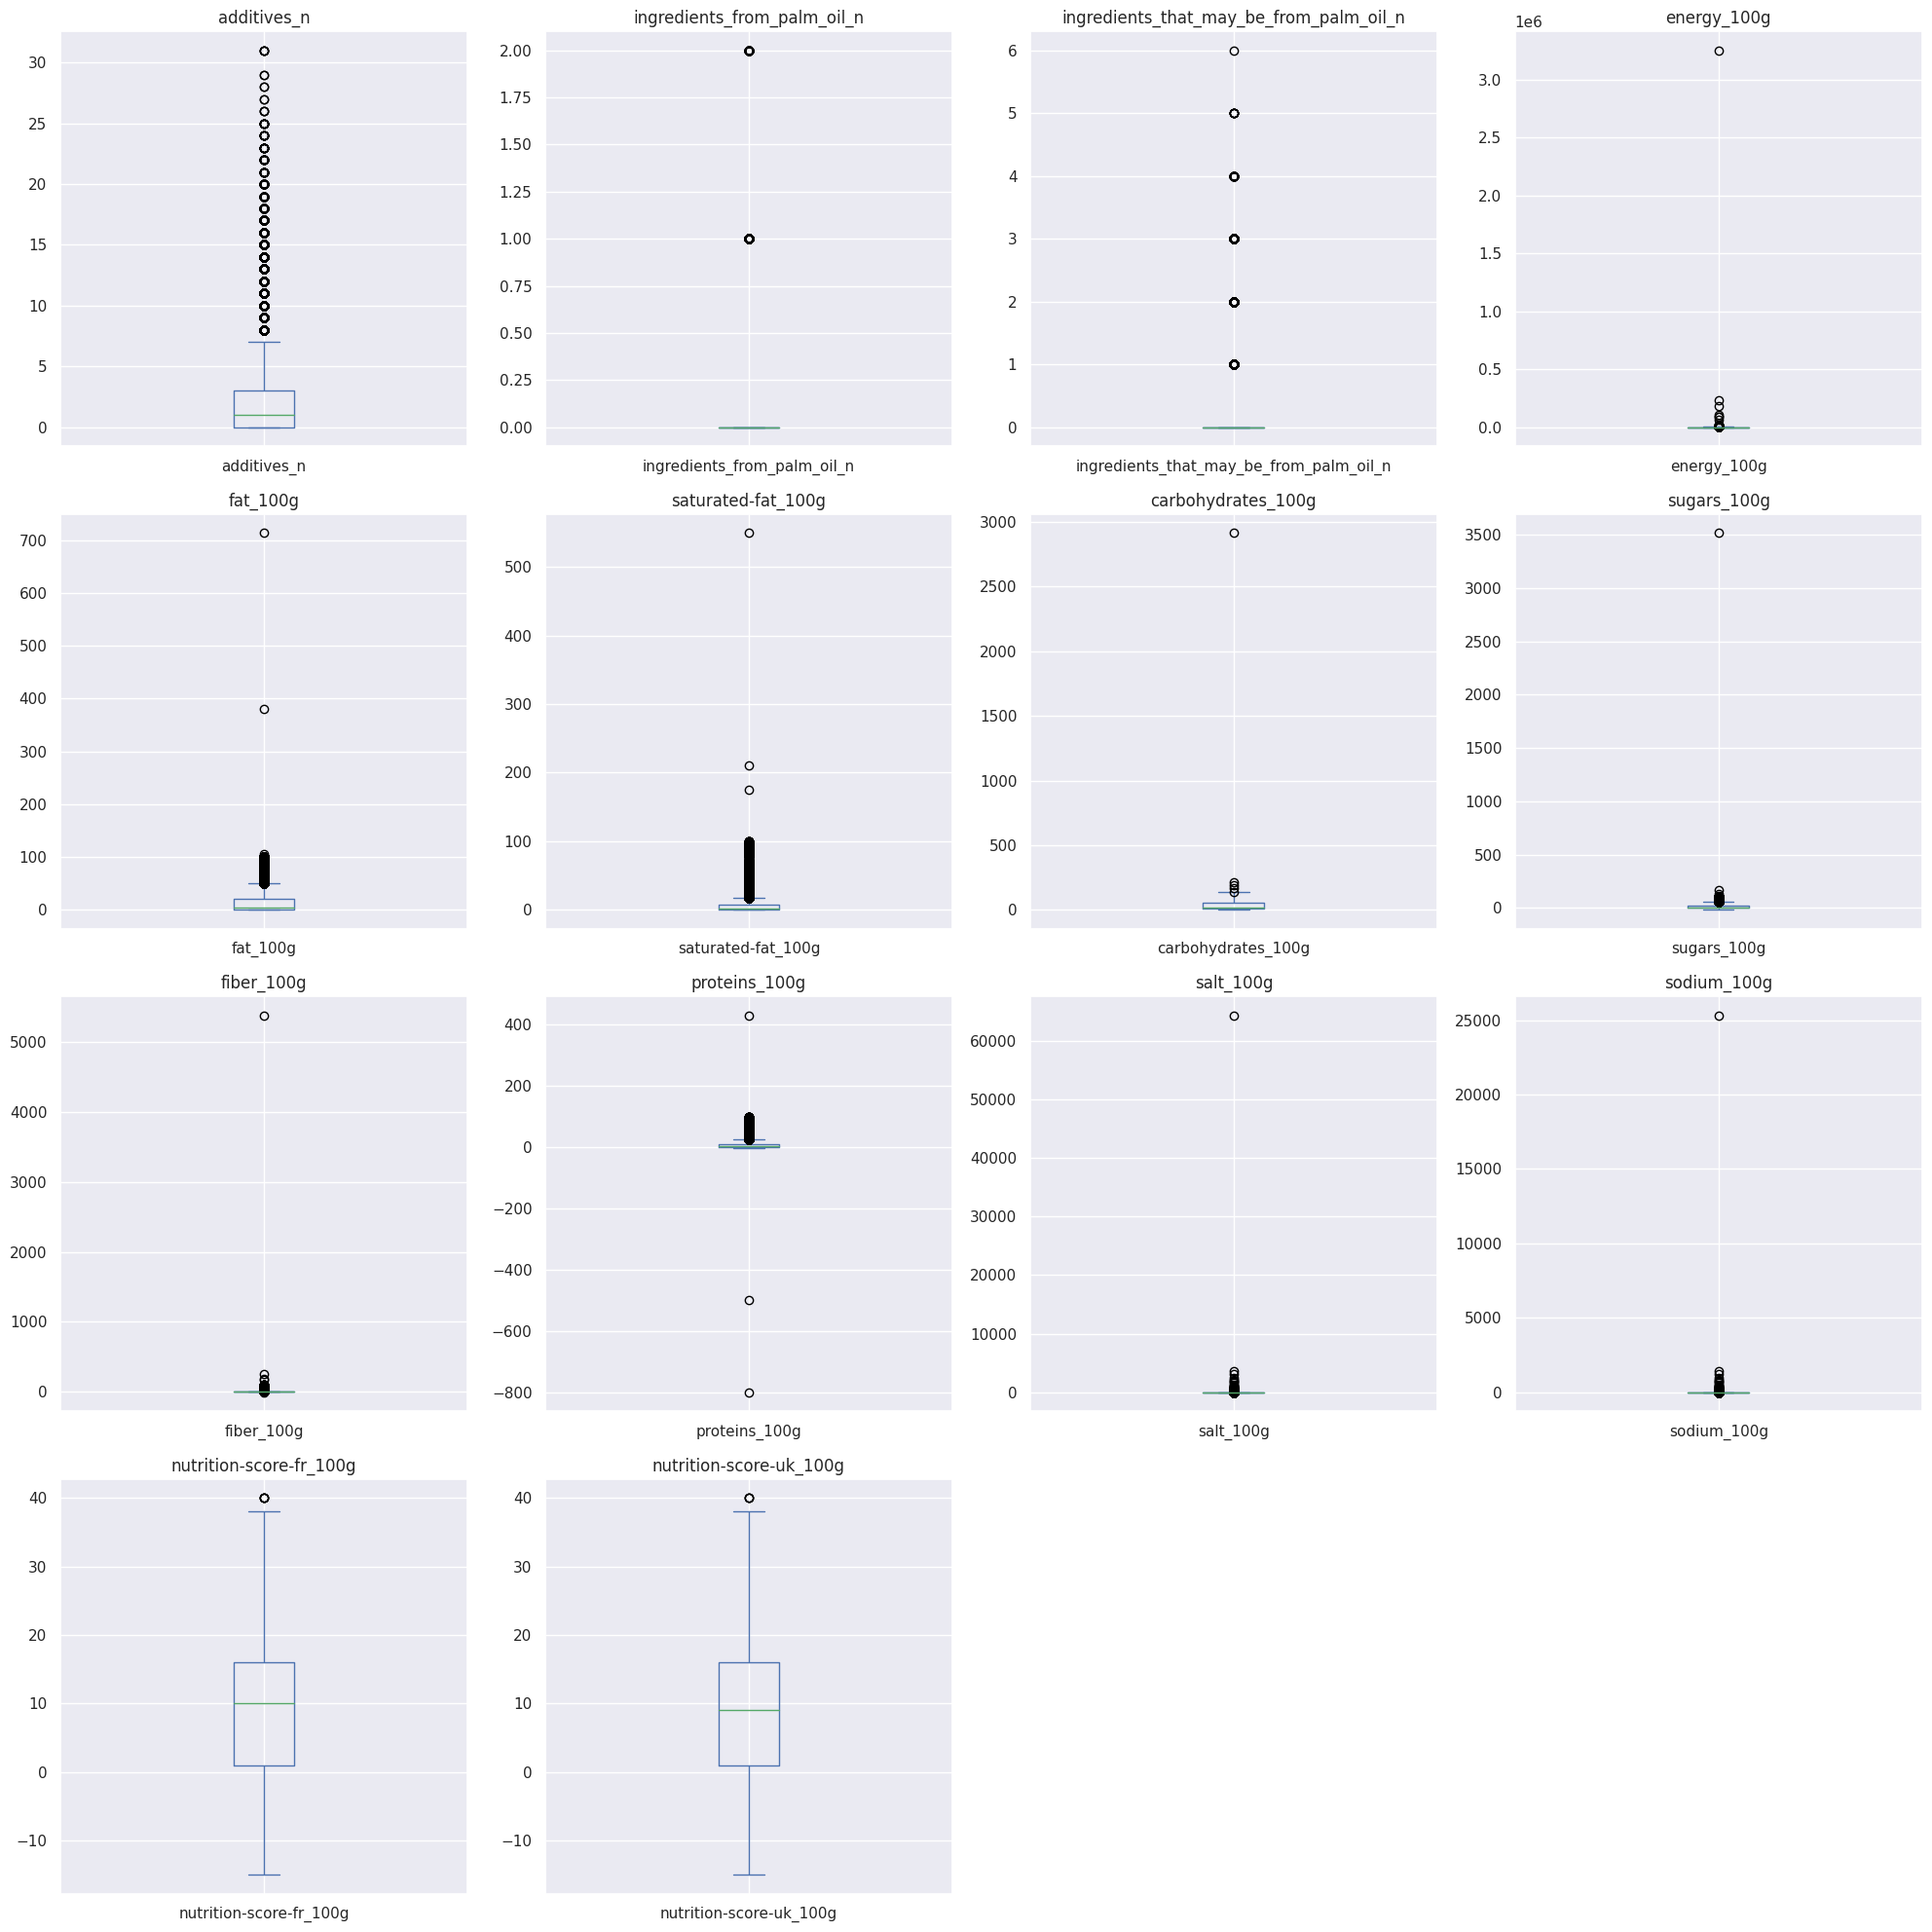

In [3]:

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n//4 if n%4 == 0 else n//4 + 1

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df[col].plot(kind='box', ax=ax)
    ax.set_title(col)

# Remove empty subplots
if n % 4:
    for i in range(n, n_rows*4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [4]:
# define relevant variables
variables = df.columns.to_list()
int_cols = df.select_dtypes(include=[int]).columns.tolist()
float_cols = df.select_dtypes(include=[float]).columns.tolist()

ignore_cols = ["nutrition-score-fr_100g",  
               "nutrition-score-uk_100g", 
               "additives_n", 
               "ingredients_from_palm_oil_n",
               "ingredients_that_may_be_from_palm_oil_n"]

# create an imputer object for numeric and categorical columns
numeric_imputer = SimpleImputer(strategy='median') # Median to acccount for the fact outliers are within data
categorical_imputer = SimpleImputer(strategy='most_frequent') # Most frequent because quick and easy

missing_value_threshold = 0.5
upper_limit = 0.75
lower_limit = 0.25
factor = 1.5

for column in variables:
    missing_values_count = df[column].isnull().sum()
    total_values = len(df[column])
    if missing_values_count / total_values <= missing_value_threshold:
        #print(f"More than 50% of the values in '{column}' are missing.")
        if (column in int_cols) or (column in float_cols):
            df[column] = numeric_imputer.fit_transform(df[column].values.reshape(-1, 1))

            if (column in float_cols) & (column not in ignore_cols):
                Q1 = df[column].quantile(lower_limit)
                Q3 = df[column].quantile(upper_limit)
                IQR = Q3 - Q1
                lower_fence = Q1 - (factor*IQR)
                upper_fence = Q3 + (factor*IQR)
                df[column].clip(upper=upper_fence, lower=lower_fence, inplace=True)
        else:
            df[column] = categorical_imputer.fit_transform(df[column].values.reshape(-1, 1))
    else:
        #print(f"Less than or equal to 50% of the values in '{column}' are missing.")
        df.drop(column, axis="columns", inplace=True)


# Univariate Analaysis

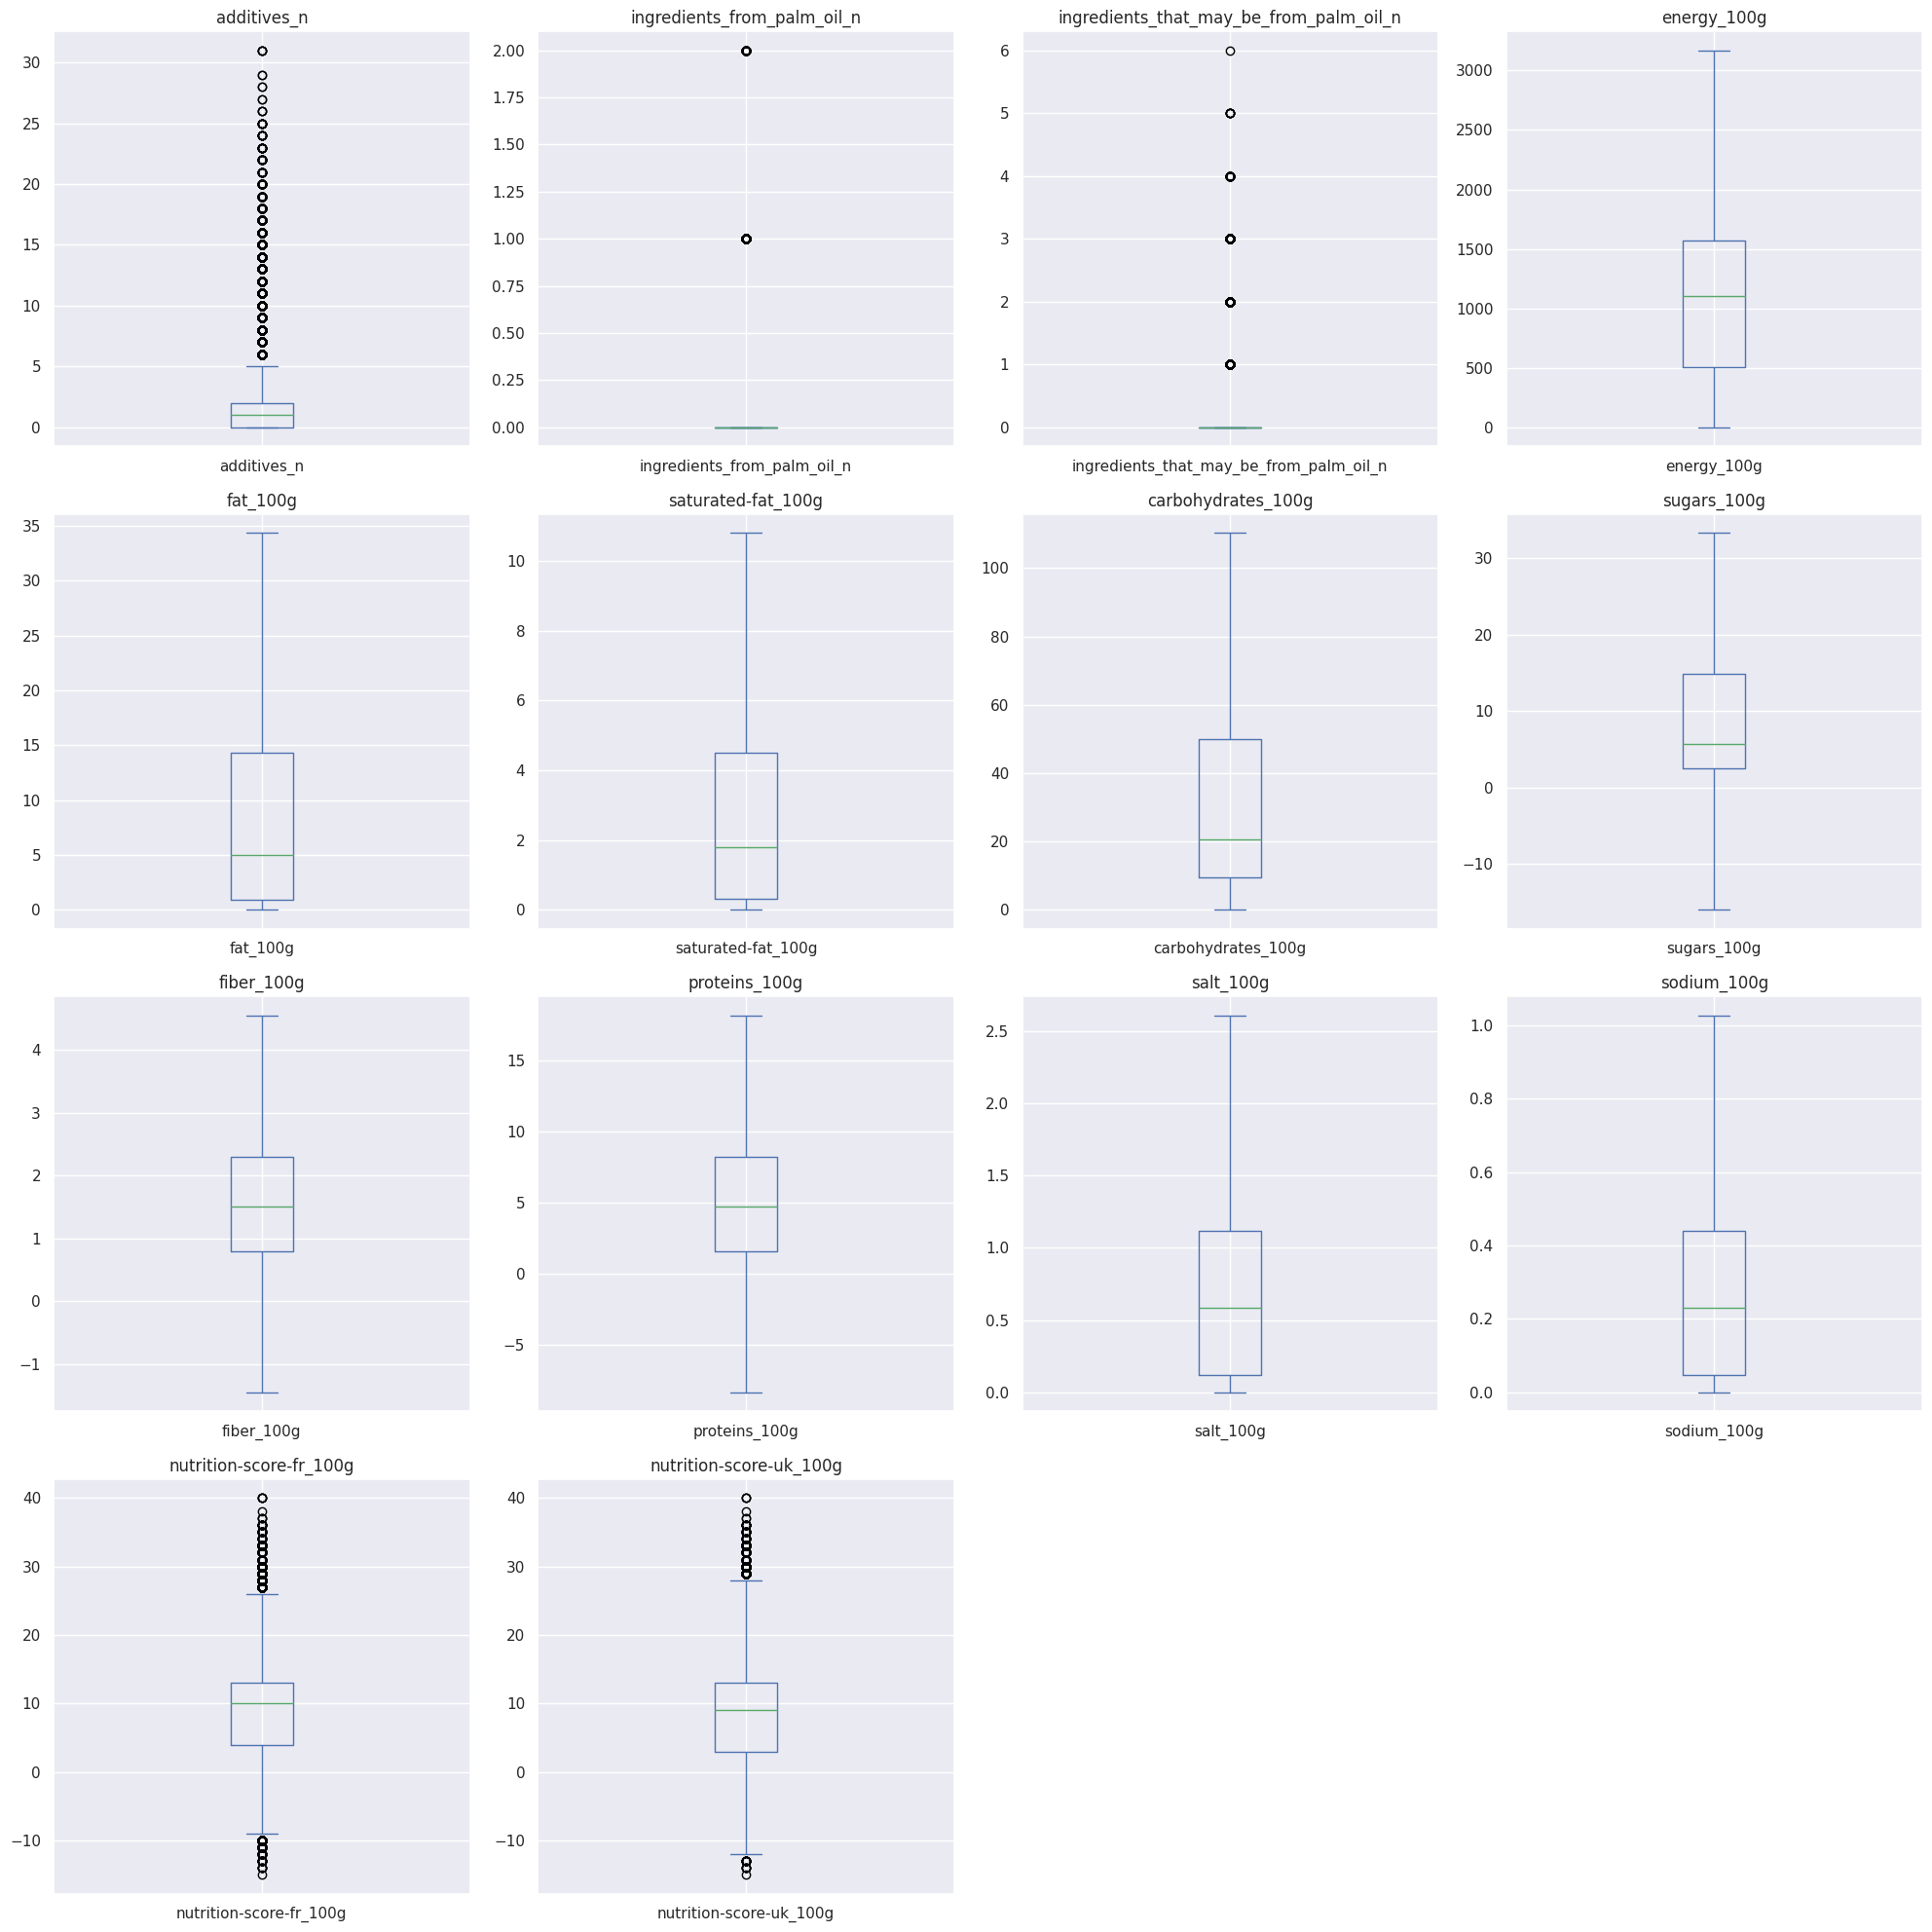

In [5]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n//4 if n%4 == 0 else n//4 + 1

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df[col].plot(kind='box', ax=ax)
    ax.set_title(col)

# Remove empty subplots
if n % 4:
    for i in range(n, n_rows*4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

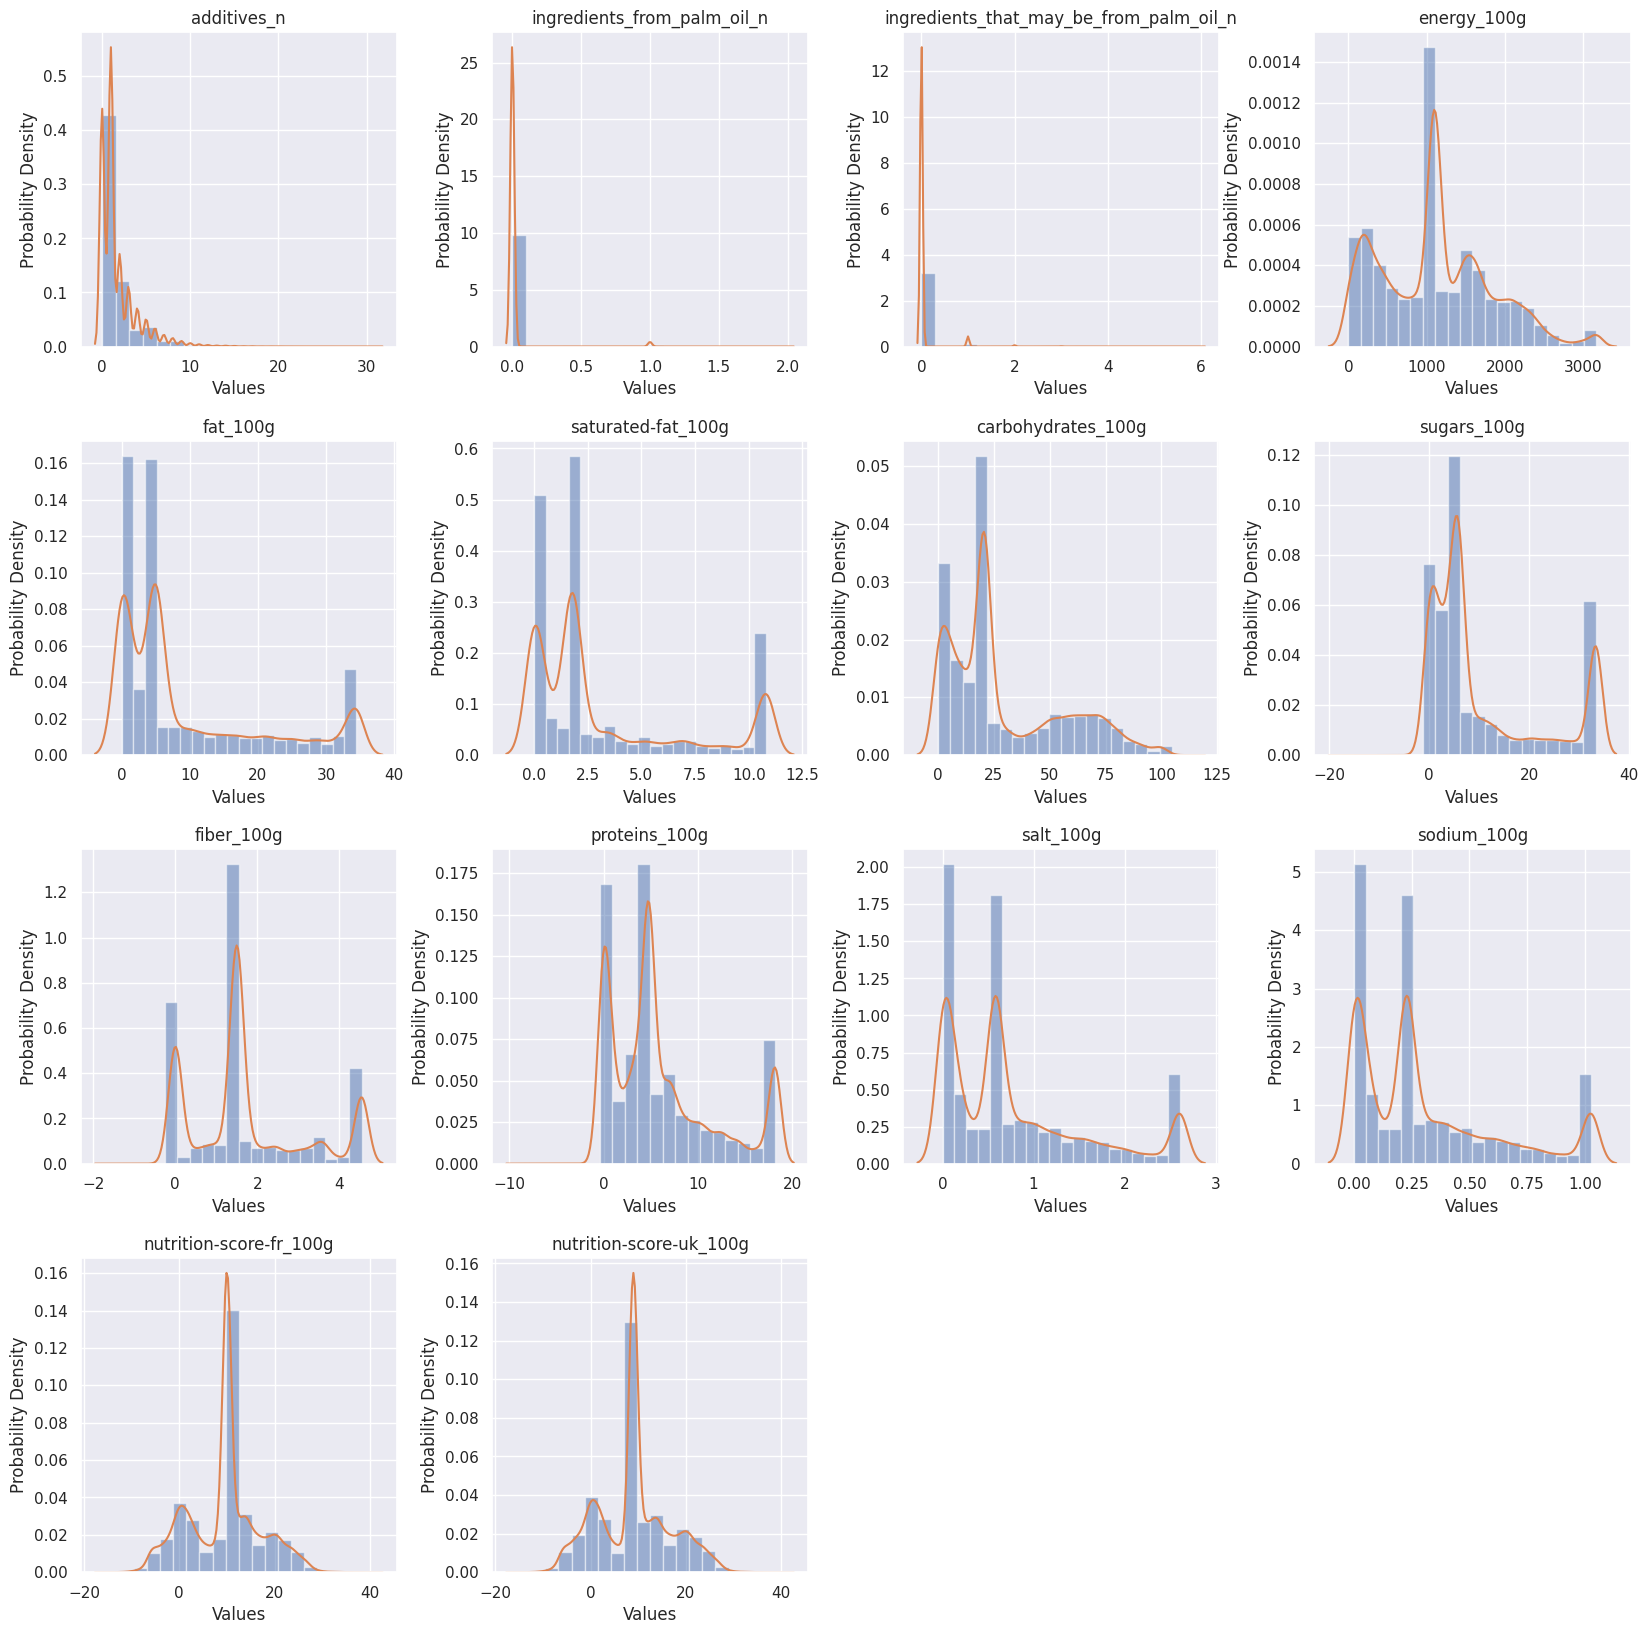

In [6]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plotting the histogram
axes = df.hist(figsize=(20,20), bins=20, density=True, alpha=0.5)

# Loop through axes and numeric columns to add KDE plot
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.kdeplot(df[col], bw_adjust=1.5, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Probability Density')

# Show the plot
plt.show()

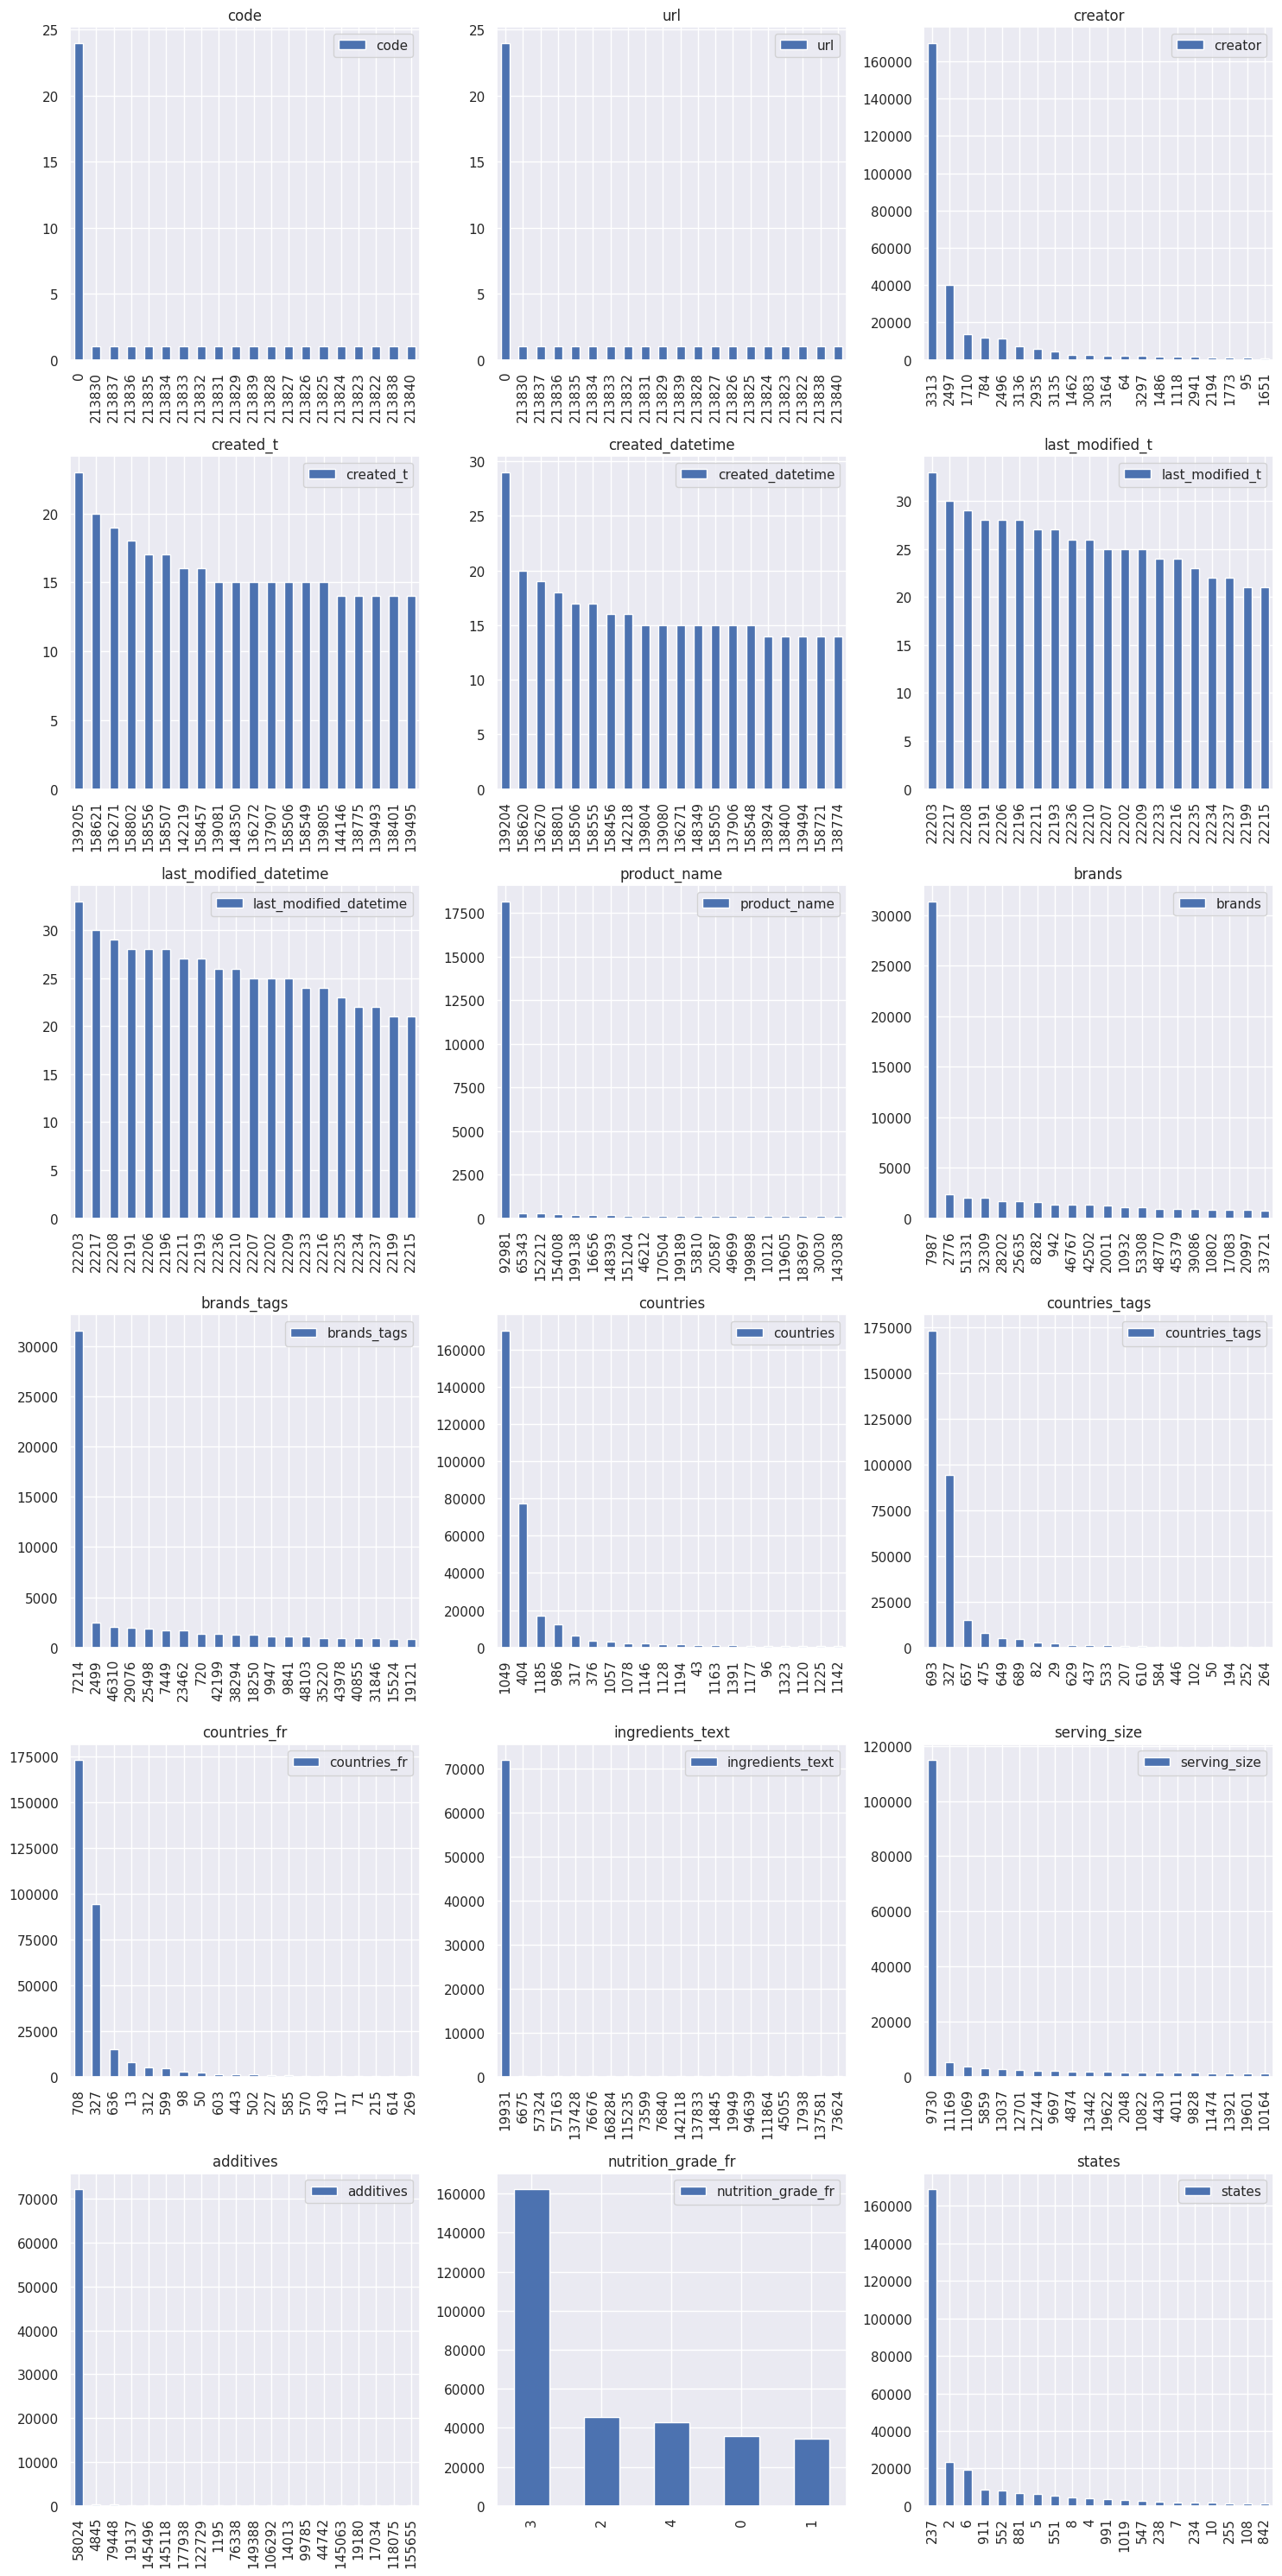

In [7]:
encoded_df = df.select_dtypes(include='object').apply(LabelEncoder().fit_transform)

object_cols = encoded_df.columns.to_list()

# Calculate number of rows needed for subplots
n = len(object_cols)
n_rows = n//3 if n%4 == 0 else n//3 + 1

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*5))

for ax, col in zip(axes.flatten(), object_cols):
    encoded_df[col].value_counts().to_frame().iloc[0:20].plot(kind='bar', ax=ax)
    ax.set_title(col)

# Remove empty subplots
if n % 4:
    for i in range(n, n_rows*4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

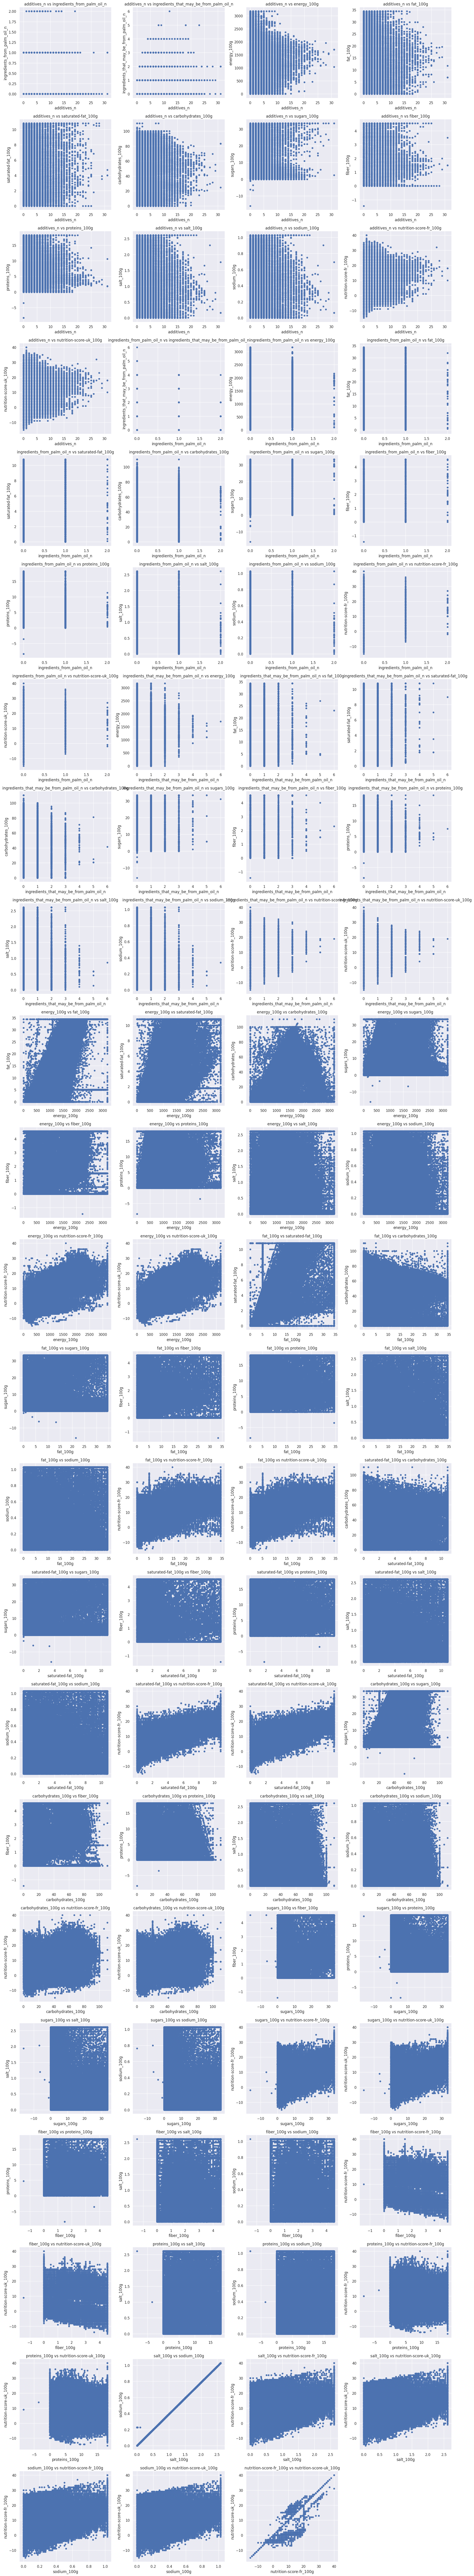

In [8]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n*(n-1)//2  # Number of unique pairs
n_cols = 4  # Number of plots per row

# Prepare the subplot grid
n_full_rows = n_rows//n_cols
n_extra_plots = n_rows%n_cols
fig, axes = plt.subplots(n_full_rows + (1 if n_extra_plots else 0), n_cols, figsize=(20, 5*n_rows//n_cols))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate over pairs of columns and create scatter plots
i = 0
for col1_idx in range(n):
    for col2_idx in range(col1_idx + 1, n):
        ax = axes[i]
        df.plot(kind='scatter', x=numeric_cols[col1_idx], y=numeric_cols[col2_idx], ax=ax)
        ax.set_title(f'{numeric_cols[col1_idx]} vs {numeric_cols[col2_idx]}')
        i += 1

# Remove empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_38372/2885793406.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_heatmap = sns.heatmap(df.corr())


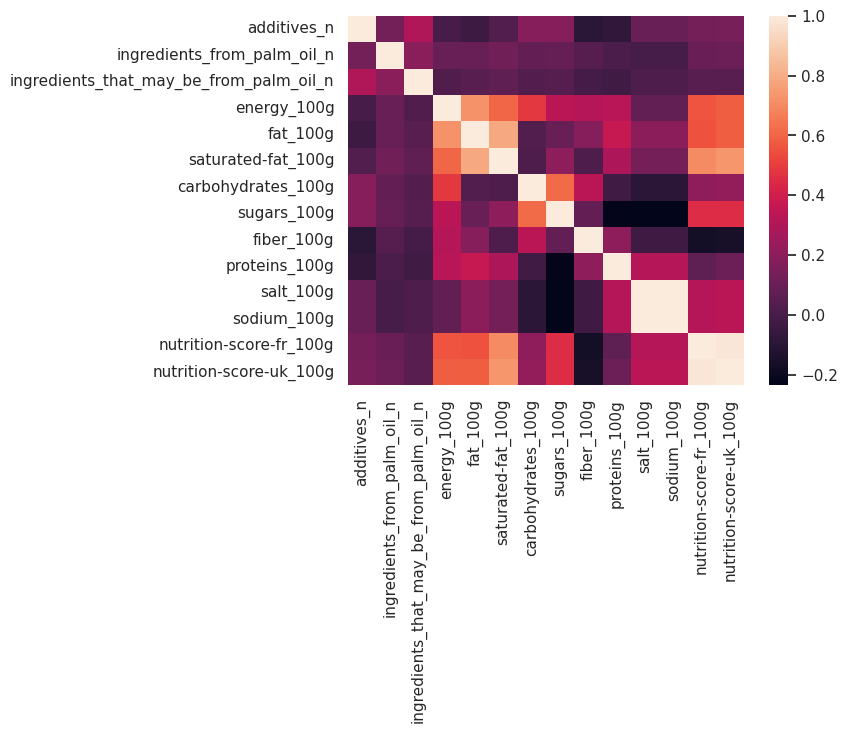

In [9]:
correlation_heatmap = sns.heatmap(df.corr())

# Notes 

- quantative ~ quantative
- quantative ~ qualataive
    - eta_squared, linear regression
- qualtative ~ qualitataive


PCA
- Statistics
- Visualisations

Explained variance ratio: [0.30567636 0.17140758 0.11972867 0.1016571  0.08806588 0.06054778]


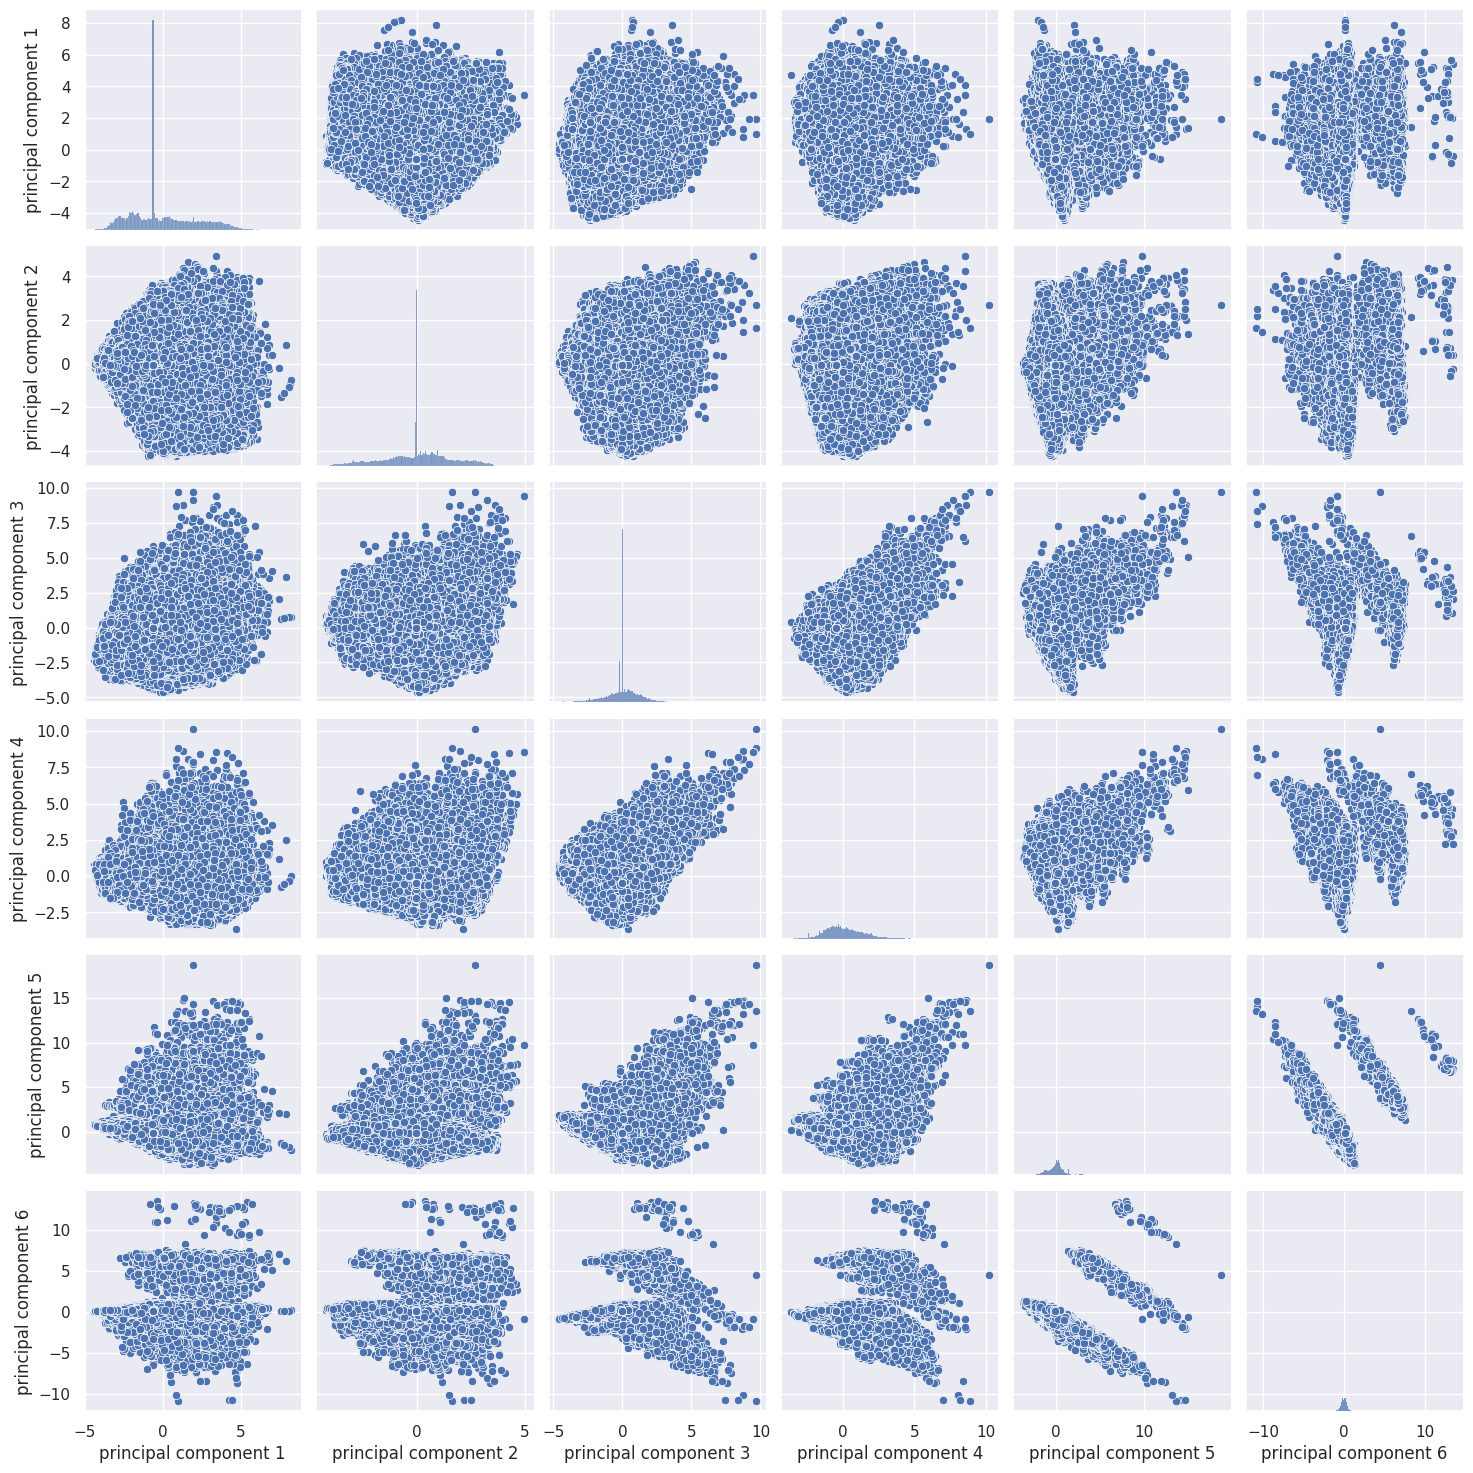

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming that df is your DataFrame and that it only contains numeric columns. If it has non-numeric columns, you should exclude them from this process.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1. Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[numeric_cols])

# 2. Apply PCA
# 2. Apply PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(scaled_df)

# 3. Convert the results back to a dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])
# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)

sns.pairplot(principalDf)

In [13]:
df[numeric_cols].iloc[:,:-2]

additives_n  ingredients_from_palm_oil_n  \
0               1.0                          0.0   
1               0.0                          0.0   
2               0.0                          0.0   
3               0.0                          0.0   
4               0.0                          0.0   
...             ...                          ...   
320767          1.0                          0.0   
320768          0.0                          0.0   
320769          1.0                          0.0   
320770          1.0                          0.0   
320771          7.0                          0.0   

        ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0                                           0.0       1100.0     5.000   
1                                           0.0       2243.0    28.570   
2                                           0.0       1941.0    17.860   
3                                           0.0       2540.0    34.375   
4                                           0.0       1552.0     1.430   
...                                         ...          ...       ...   
320767                                      0.0       1100.0     5.000   
320768                                      0.0          0.0     0.000   
320769                                      0.0       1100.0     5.000   
320770                                      0.0       1100.0     5.000   
320771                                      0.0       2092.0     0.000   

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                     1.79               20.60         5.71        1.50   
1                    10.80               64.29        14.29        3.60   
2                     0.00               60.71        17.86        4.55   
3                     5.36               17.86         3.57        4.55   
4                     1.79               77.14         5.71        4.55   
...                    ...                 ...          ...         ...   
320767                1.79               20.60         5.71        1.50   
320768                0.00                0.00         0.00        0.00   
320769                1.79               20.60         5.71        1.50   
320770                1.79               20.60         5.71        1.50   
320771                1.79                0.00         0.00        1.50   

        proteins_100g  salt_100g  sodium_100g  
0                4.76    0.58166        0.229  
1                3.57    0.00000        0.000  
2               17.86    0.63500        0.250  
3               17.86    1.22428        0.482  
4                8.57    0.58166        0.229  
...               ...        ...          ...  
320767           4.76    0.58166        0.229  
320768           0.00    0.00000        0.000  
320769           4.76    0.58166        0.229  
320770           4.76    0.58166        0.229  
320771           0.00    0.00000        0.000  

[320772 rows x 12 columns]

In [14]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

X = df[numeric_cols].iloc[:,:-2]
Y = df[numeric_cols].iloc[:,-1]


model = LinearRegression()
selector = RFE(model, step=1)

selector = selector.fit(X, Y)

X_transformed = selector.transform(X)

model.fit(X_transformed, Y)


LinearRegression()

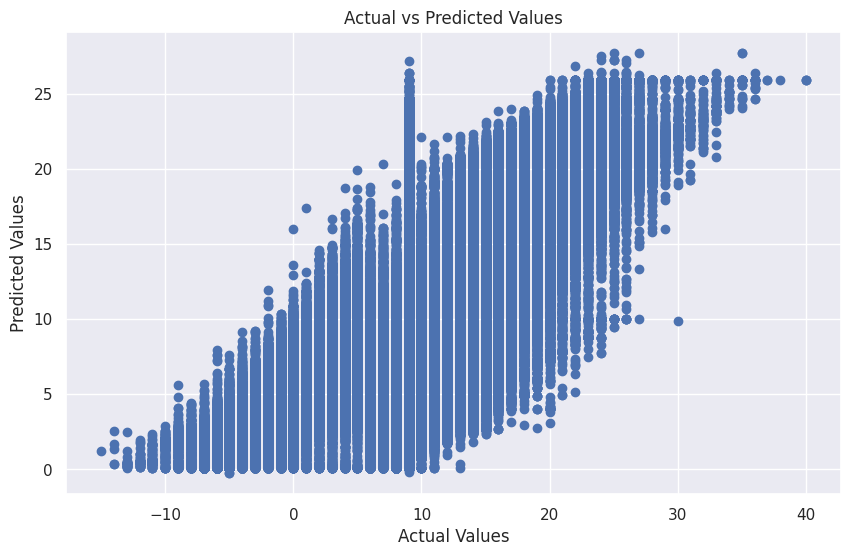

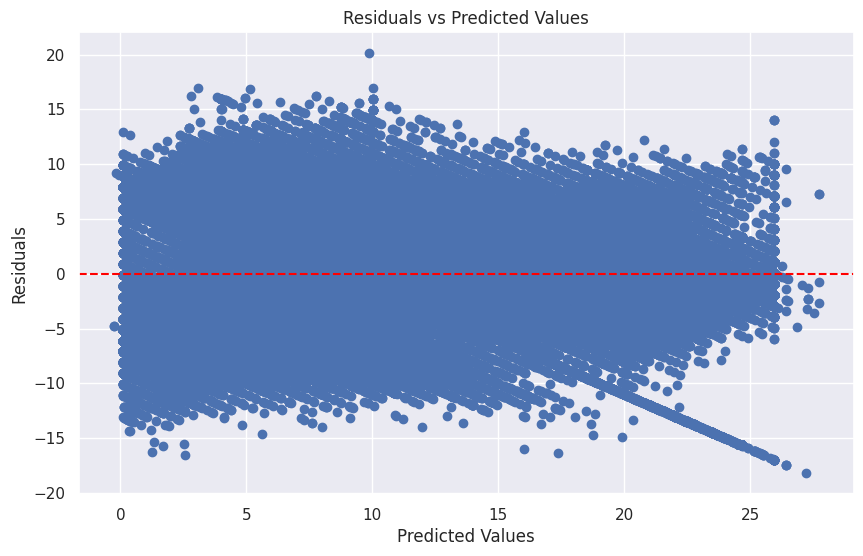

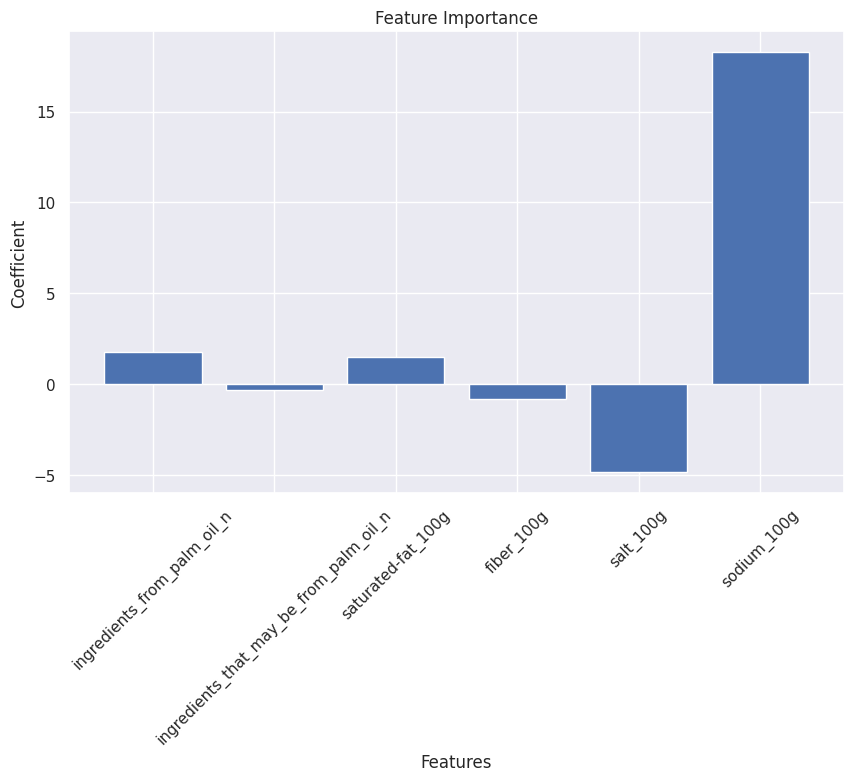

In [15]:
y_pred = model.predict(X_transformed)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(Y, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

residuals = Y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


selected_features = X.columns[selector.support_]
feature_importance = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(selected_features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


In [16]:
X[X.columns[selector.support_].to_list()]

ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0                               0.0                                      0.0   
1                               0.0                                      0.0   
2                               0.0                                      0.0   
3                               0.0                                      0.0   
4                               0.0                                      0.0   
...                             ...                                      ...   
320767                          0.0                                      0.0   
320768                          0.0                                      0.0   
320769                          0.0                                      0.0   
320770                          0.0                                      0.0   
320771                          0.0                                      0.0   

        saturated-fat_100g  fiber_100g  salt_100g  sodium_100g  
0                     1.79        1.50    0.58166        0.229  
1                    10.80        3.60    0.00000        0.000  
2                     0.00        4.55    0.63500        0.250  
3                     5.36        4.55    1.22428        0.482  
4                     1.79        4.55    0.58166        0.229  
...                    ...         ...        ...          ...  
320767                1.79        1.50    0.58166        0.229  
320768                0.00        0.00    0.00000        0.000  
320769                1.79        1.50    0.58166        0.229  
320770                1.79        1.50    0.58166        0.229  
320771                1.79        1.50    0.00000        0.000  

[320772 rows x 6 columns]

In [18]:
import statsmodels.api as sm

X = X[X.columns[selector.support_].to_list()]
X_with_constant = sm.add_constant(X)
model = sm.OLS(df[numeric_cols[-1]], X_with_constant).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition-score-uk_100g   R-squared:                       0.927
Model:                                 OLS   Adj. R-squared:                  0.927
Method:                      Least Squares   F-statistic:                 2.529e+05
Date:                     Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                             20:41:31   Log-Likelihood:            -6.8806e+05
No. Observations:                   320772   AIC:                         1.376e+06
Df Residuals:                       320755   BIC:                         1.376e+06
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [12]:
import statsmodels.api as sm

X = df[numeric_cols[:-2]]
X_with_constant = sm.add_constant(X)
model = sm.OLS(df[numeric_cols[-2]], X_with_constant).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition-score-fr_100g   R-squared:                       0.776
Model:                                 OLS   Adj. R-squared:                  0.776
Method:                      Least Squares   F-statistic:                 9.250e+04
Date:                     Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                             05:44:07   Log-Likelihood:            -8.6295e+05
No. Observations:                   320772   AIC:                         1.726e+06
Df Residuals:                       320759   BIC:                         1.726e+06
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

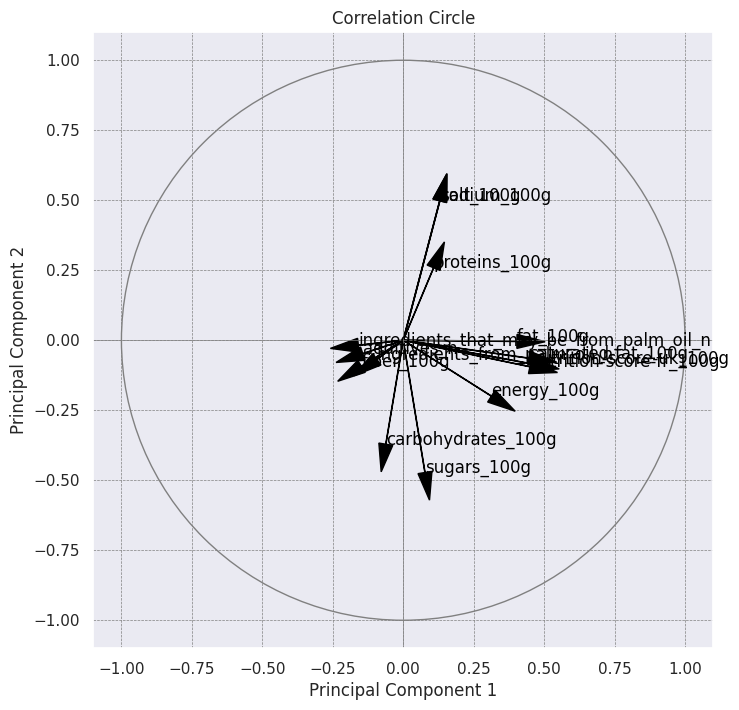

In [17]:
correlation_matrix = df[numeric_cols].corr()
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(correlation_matrix)

loadings = pca.components_.T

fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
ax.add_artist(circle)

for i, (loading_1, loading_2) in enumerate(loadings):
    ax.arrow(0, 0, loading_1, loading_2, head_width=0.05, head_length=0.1, fc='black', ec='black')
    plt.text(loading_1, loading_2, df[numeric_cols].columns[i], color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Correlation Circle')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


In [24]:
df.iloc[:, 0:8]

code                                                url  \
0       0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1       0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2       0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3       0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4       0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
320767  9948282780603  http://world-fr.openfoodfacts.org/produit/9948...   
320768       99567453  http://world-fr.openfoodfacts.org/produit/9956...   
320769  9970229501521  http://world-fr.openfoodfacts.org/produit/9970...   
320770  9980282863788  http://world-fr.openfoodfacts.org/produit/9980...   
320771   999990026839  http://world-fr.openfoodfacts.org/produit/9999...   

                           creator   created_t      created_datetime  \
0       openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1                  usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2                  usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3                  usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4                  usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
...                            ...         ...                   ...   
320767  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
320768             usda-ndb-import  1489059076  2017-03-09T11:31:16Z   
320769                      tomato  1422099377  2015-01-24T11:36:17Z   
320770  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
320771             usda-ndb-import  1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
0           1474103893   2016-09-17T09:18:13Z   
1           1489069957   2017-03-09T14:32:37Z   
2           1489069957   2017-03-09T14:32:37Z   
3           1489055731   2017-03-09T10:35:31Z   
4           1489055653   2017-03-09T10:34:13Z   
...                ...                    ...   
320767      1491244498   2017-04-03T18:34:58Z   
320768      1491244499   2017-04-03T18:34:59Z   
320769      1491244499   2017-04-03T18:34:59Z   
320770      1492340089   2017-04-16T10:54:49Z   
320771      1491244499   2017-04-03T18:34:59Z   

                                             product_name  
0                                      Farine de blé noir  
1                          Banana Chips Sweetened (Whole)  
2                                                 Peanuts  
3                                  Organic Salted Nut Mix  
4                                         Organic Polenta  
...                                                   ...  
320767                                  Tomato & ricotta   
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...  
320769                                            乐吧泡菜味薯片  
320770                           Tomates aux Vermicelles   
320771                    Sugar Free Drink Mix, Peach Tea  

[320772 rows x 8 columns]

In [26]:
df.iloc[:, 8:16]

brands      brands_tags countries    countries_tags  \
0       Ferme t'y R'nao  ferme-t-y-r-nao     en:FR         en:france   
1             Carrefour        carrefour        US  en:united-states   
2        Torn & Glasser     torn-glasser        US  en:united-states   
3             Grizzlies        grizzlies        US  en:united-states   
4        Bob's Red Mill   bob-s-red-mill        US  en:united-states   
...                 ...              ...       ...               ...   
320767         Panzani           panzani     en:RO        en:romania   
320768     Trader Joe's     trader-joe-s        US  en:united-states   
320769               乐吧               乐吧     China          en:china   
320770            Knorr            knorr     en:FR         en:france   
320771    Market Pantry    market-pantry        US  en:united-states   

       countries_fr                                   ingredients_text  \
0            France                  Carbonated water, natural flavor.   
1        États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...   
2        États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...   
3        États-Unis  Organic hazelnuts, organic cashews, organic wa...   
4        États-Unis                                    Organic polenta   
...             ...                                                ...   
320767     Roumanie                  Carbonated water, natural flavor.   
320768   États-Unis  Organic peppermint, organic lemon grass, organ...   
320769        Chine                  Carbonated water, natural flavor.   
320770       France                  Carbonated water, natural flavor.   
320771   États-Unis  Citric acid, maltodextrin, instant tea, aspart...   

            serving_size  additives_n  
0       240 ml (8 fl oz)          1.0  
1           28 g (1 ONZ)          0.0  
2        28 g (0.25 cup)          0.0  
3        28 g (0.25 cup)          0.0  
4        35 g (0.25 cup)          0.0  
...                  ...          ...  
320767  240 ml (8 fl oz)          1.0  
320768     20 g (0.7 oz)          0.0  
320769  240 ml (8 fl oz)          1.0  
320770  240 ml (8 fl oz)          1.0  
320771  1 g (0.5 PACKET)          7.0  

[320772 rows x 8 columns]

In [30]:
df["additives"].unique()

array([' [ extra-virgin-olive-oil -> en:extra-virgin-olive-oil  ]  [ virgin-olive-oil -> en:virgin-olive-oil  ]  [ olive-oil -> en:olive-oil  ]  [ oil -> en:oil  ] ',
       ' [ bananas -> en:bananas  ]  [ vegetable-oil -> en:vegetable-oil  ]  [ oil -> en:oil  ]  [ coconut-oil -> en:coconut-oil  ]  [ oil -> en:oil  ]  [ corn-oil-and-or-palm-oil-sugar -> en:corn-oil-and-or-palm-oil-sugar  ]  [ oil-and-or-palm-oil-sugar -> en:oil-and-or-palm-oil-sugar  ]  [ and-or-palm-oil-sugar -> en:and-or-palm-oil-sugar  ]  [ or-palm-oil-sugar -> en:or-palm-oil-sugar  ]  [ palm-oil-sugar -> en:palm-oil-sugar  ]  [ oil-sugar -> en:oil-sugar  ]  [ sugar -> en:sugar  ]  [ natural-banana-flavor -> en:natural-banana-flavor  ]  [ banana-flavor -> en:banana-flavor  ]  [ flavor -> en:flavor  ] ',
       ' [ peanuts -> en:peanuts  ]  [ wheat-flour -> en:wheat-flour  ]  [ flour -> en:flour  ]  [ sugar -> en:sugar  ]  [ rice-flour -> en:rice-flour  ]  [ flour -> en:flour  ]  [ tapioca-starch -> en:tapioca-starch

In [ ]:
["states", "states_tags", "states_fr", "additives", "countries_tags", "ingredients_text", "serving_size", "countries", "countries_fr", "brands"]

In [27]:
df.iloc[:, 16:24]

additives  \
0        [ extra-virgin-olive-oil -> en:extra-virgin-o...   
1        [ bananas -> en:bananas  ]  [ vegetable-oil -...   
2        [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...   
3        [ organic-hazelnuts -> en:organic-hazelnuts  ...   
4        [ organic-polenta -> en:organic-polenta  ]  [...   
...                                                   ...   
320767   [ extra-virgin-olive-oil -> en:extra-virgin-o...   
320768   [ organic-peppermint -> en:organic-peppermint...   
320769   [ extra-virgin-olive-oil -> en:extra-virgin-o...   
320770   [ extra-virgin-olive-oil -> en:extra-virgin-o...   
320771   [ citric-acid -> en:e330  -> exists  -- ok  ]...   

        ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0                               0.0                                      0.0   
1                               0.0                                      0.0   
2                               0.0                                      0.0   
3                               0.0                                      0.0   
4                               0.0                                      0.0   
...                             ...                                      ...   
320767                          0.0                                      0.0   
320768                          0.0                                      0.0   
320769                          0.0                                      0.0   
320770                          0.0                                      0.0   
320771                          0.0                                      0.0   

       nutrition_grade_fr                                             states  \
0                       d  en:to-be-completed, en:nutrition-facts-to-be-c...   
1                       d  en:to-be-completed, en:nutrition-facts-complet...   
2                       b  en:to-be-completed, en:nutrition-facts-complet...   
3                       d  en:to-be-completed, en:nutrition-facts-complet...   
4                       d  en:to-be-completed, en:nutrition-facts-complet...   
...                   ...                                                ...   
320767                  d  en:to-be-completed, en:nutrition-facts-to-be-c...   
320768                  b  en:to-be-completed, en:nutrition-facts-complet...   
320769                  d  en:to-be-completed, en:nutrition-facts-to-be-c...   
320770                  d  en:to-be-completed, en:nutrition-facts-to-be-c...   
320771                  d  en:to-be-completed, en:nutrition-facts-complet...   

                                              states_tags  \
0       en:to-be-completed,en:nutrition-facts-to-be-co...   
1       en:to-be-completed,en:nutrition-facts-complete...   
2       en:to-be-completed,en:nutrition-facts-complete...   
3       en:to-be-completed,en:nutrition-facts-complete...   
4       en:to-be-completed,en:nutrition-facts-complete...   
...                                                   ...   
320767  en:to-be-completed,en:nutrition-facts-to-be-co...   
320768  en:to-be-completed,en:nutrition-facts-complete...   
320769  en:to-be-completed,en:nutrition-facts-to-be-co...   
320770  en:to-be-completed,en:nutrition-facts-to-be-co...   
320771  en:to-be-completed,en:nutrition-facts-complete...   

                                                states_fr  energy_100g  
0       A compléter,Informations nutritionnelles à com...       1100.0  
1       A compléter,Informations nutritionnelles compl...       2243.0  
2       A compléter,Informations nutritionnelles compl...       1941.0  
3       A compléter,Informations nutritionnelles compl...       2540.0  
4       A compléter,Informations nutritionnelles compl...       1552.0  
...                                                   ...          ...  
320767  A compléter,Informations nutritionnelles à com...       1100.0  
320768  A compléter,Informations nutritionnelles compl...          0.0  
320

In [28]:
df.iloc[:, 24:]

fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0          5.000                1.79               20.60         5.71   
1         28.570               10.80               64.29        14.29   
2         17.860                0.00               60.71        17.86   
3         34.375                5.36               17.86         3.57   
4          1.430                1.79               77.14         5.71   
...          ...                 ...                 ...          ...   
320767     5.000                1.79               20.60         5.71   
320768     0.000                0.00                0.00         0.00   
320769     5.000                1.79               20.60         5.71   
320770     5.000                1.79               20.60         5.71   
320771     0.000                1.79                0.00         0.00   

        fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0             1.50           4.76    0.58166        0.229   
1             3.60           3.57    0.00000        0.000   
2             4.55          17.86    0.63500        0.250   
3             4.55          17.86    1.22428        0.482   
4             4.55           8.57    0.58166        0.229   
...            ...            ...        ...          ...   
320767        1.50           4.76    0.58166        0.229   
320768        0.00           0.00    0.00000        0.000   
320769        1.50           4.76    0.58166        0.229   
320770        1.50           4.76    0.58166        0.229   
320771        1.50           0.00    0.00000        0.000   

        nutrition-score-fr_100g  nutrition-score-uk_100g  
0                          10.0                      9.0  
1                          14.0                     14.0  
2                           0.0                      0.0  
3                          12.0                     12.0  
4                          10.0                      9.0  
...                         ...                      ...  
320767                     10.0                      9.0  
320768                      0.0                      0.0  
320769                     10.0                      9.0  
320770                     10.0                      9.0  
320771                     10.0                      9.0  

[320772 rows x 10 columns]